In [1]:
! pip install numpy
! pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import heapq

In [2]:
""" cellData = {
    'type', 
    'realCoord' 
    'risk', 
    'isTransition',
    'exitCoord' 
} """
class CellData:
    def __init__(self, cell_type, real_coord, risk, exit_coord=False):
        self.cell_type = cell_type # -1= obstacle, 0=empty, 1=currentposition, 2=goal, 3=transition
        self.real_coord = real_coord # this is the real coordinate at the real world
        self.risk = risk # 0=low, 1=high

        self.exit_coord = exit_coord #Only if is transition type

    def __repr__(self):
        return (f"CellData(type={self.cell_type}, real_coord={self.real_coord}, "
                f"risk={self.risk}, exit_coord={self.exit_coord})")

In [3]:
# -1= obstacle, 0= empty, 1= current_position, 2= goal, 3= transition

rows, cols = 10, 10
grid = np.zeros((rows, cols), dtype=CellData)

for i in range(rows):
    for j in range(cols):
        grid[i, j] = CellData(cell_type=0, real_coord=(i, j), risk=0)

##Set obstacles
for i in range(2,7):
    for j in range(3,7):
        grid[i,j].cell_type = -1

grid[0,3].cell_type = -1
grid[1,3].cell_type = -1

# Set the risk to 1 for every cell beside an obstacle cell
for i in range(rows):
    for j in range(cols):
        if grid[i, j].cell_type == -1:
            grid[i, j].risk = 0  # Ensure obstacles have risk 0
            if i > 0 and grid[i-1, j].cell_type != -1:
                grid[i-1, j].risk = 1
            if i < rows-1 and grid[i+1, j].cell_type != -1:
                grid[i+1, j].risk = 1
            if j > 0 and grid[i, j-1].cell_type != -1:
                grid[i, j-1].risk = 1
            if j < cols-1 and grid[i, j+1].cell_type != -1:
                grid[i, j+1].risk = 1


# Set the risk to 1 for border cells of the matrix
for i in range(rows):
    grid[i, 0].risk = 1
    grid[i, cols-1].risk = 1
for j in range(cols):
    grid[0, j].risk = 1
    grid[rows-1, j].risk = 1
    
##Set start, goal, transition
start_index= (1,4)
goal_index = (7, 2)
transition_index = (0,1)

grid[start_index[0],start_index[1]].cell_type = 1 #current_position
grid[goal_index[0],goal_index[1]].cell_type = 2 #goal
grid[transition_index[0],transition_index[1]].cell_type = 3 #transition



In [4]:
import heapq

class Node:
    def __init__(self, position, parent=None, g=0, h=0, f=0):
        self.position = position
        self.parent = parent
        self.g = g  # Movement cost
        self.h = h  # Heuristic cost
        self.f = f  # Total cost
        self.risk = 0  # Risk cost

    def __eq__(self, other):
        return self.position == other.position

    def __lt__(self, other):
        return self.f < other.f

def manhattan_heuristic(position, goal):
    return abs(position[0] - goal[0]) + abs(position[1] - goal[1])

def a_star_search(start, goal, grid):
    open_list = []
    closed_list = set()
    start_node = Node(start)
    start_node.h = manhattan_heuristic(start, goal)
    start_node.f = start_node.h
    heapq.heappush(open_list, start_node)

    while open_list:
        current_node = heapq.heappop(open_list)
        closed_list.add(current_node.position)

        if current_node.position == goal:
            path = []
            while current_node is not None:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]

        neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        for offset in neighbors:
            neighbor_position = (current_node.position[0] + offset[0], current_node.position[1] + offset[1])
            if not (0 <= neighbor_position[0] < grid.shape[0]) or not (0 <= neighbor_position[1] < grid.shape[1]):
                continue

            if grid[neighbor_position].cell_type == -1:
                continue

            neighbor_node = Node(neighbor_position, current_node)
            neighbor_node.g = current_node.g + 1 + grid[neighbor_position].risk
            neighbor_node.h = manhattan_heuristic(neighbor_position, goal)
            neighbor_node.f = neighbor_node.g + neighbor_node.h

            if neighbor_position in closed_list:
                continue

            if any(open_node for open_node in open_list if neighbor_node == open_node and neighbor_node.f >= open_node.f):
                continue

            heapq.heappush(open_list, neighbor_node)

    return None
# Perform A* search
path = a_star_search(start_index, goal_index, grid)
print("Path:", path)


Path: [(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (7, 7), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (7, 2)]


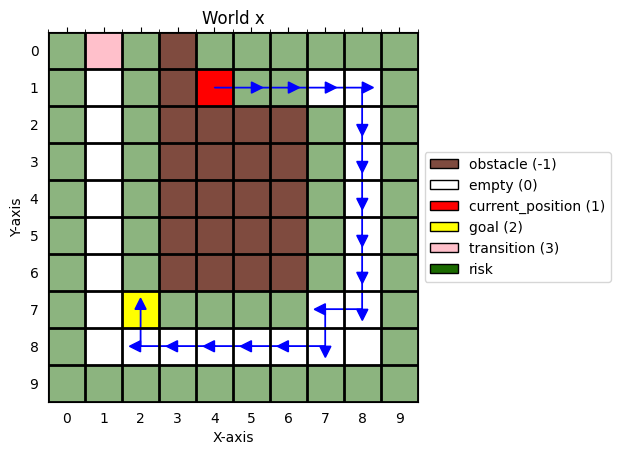

In [31]:
# Extract the cell types for visualization
cell_types = np.array([[grid[i, j].cell_type for j in range(cols)] for i in range(rows)])

# Create a custom colormap -1= obstacle, 0= empty, 1= current_position, 2= goal, 3= transition, 4= risk 1
brown = (127/255, 75/255, 63/255)
white = (255/255, 255/255, 255/255)
red = (255/255, 0/255, 0/255)
yellow = (255/255, 255/255, 0/255)
pink = (255/255, 192/255, 203/255)
green = (27/255, 106/255, 0/255)  # green for risk 1 cells

cmap = plt.cm.colors.ListedColormap([brown, white,red,yellow, pink], name='from_list', N=None)

# Create a heatmap with grid lines and cell data
fig, ax = plt.subplots()
cax = ax.matshow(cell_types, cmap=cmap)

# Highlight risk 1 cells in green
for i in range(rows):
    for j in range(cols):
        if grid[i, j].risk == 1 and grid[i, j].cell_type == 0:
            ax.add_patch(patches.Rectangle((j-0.5, i-0.5), 1, 1, edgecolor='none', facecolor=green, alpha=0.5))


# Draw arrows for the path
for i in range(1, len(path)):
    start_cell = path[i-1]
    end_cell = path[i]
    ax.arrow(start_cell[1], start_cell[0], end_cell[1] - start_cell[1], end_cell[0] - start_cell[0], 
             head_width=0.3, head_length=0.3, fc='blue', ec='blue')

# Set the grid lines
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# Show row and column numbers starting from 0
ax.set_xticks(np.arange(0, cols, 1))
ax.set_yticks(np.arange(0, rows, 1))
ax.set_xticklabels(np.arange(0, cols, 1))
ax.set_yticklabels(np.arange(0, rows, 1))

# Show ticks and labels
ax.tick_params(which='both', bottom=False, left=False, labelbottom=True, labelleft=True, labeltop=False, labelright=False)

# Add a legend outside the plot
legend_elements = [
    patches.Patch(facecolor=brown, edgecolor='black', label='obstacle (-1)'),
    patches.Patch(facecolor=white, edgecolor='black', label='empty (0)'),
    patches.Patch(facecolor=red, edgecolor='black', label='current_position (1)'),
    patches.Patch(facecolor=yellow, edgecolor='black', label='goal (2)'),
    patches.Patch(facecolor=pink, edgecolor='black', label='transition (3)'),
    patches.Patch(facecolor=green, edgecolor='black', label='risk')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('World x')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.show()
